In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import multivariate_normal
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# !pip install seaborn
# !pip install scipy

In [4]:
def branching_diffusion_with_death(num_particles, steps, branch_prob, death_prob, diff_std, max_particles=10,
                                  smin=-10, smax=-5, new_particle_prob=0.1):
    positions = np.zeros((steps, max_particles))
    alive = np.zeros((steps, max_particles), dtype=bool)
    colors = [
        'red', 'green', 'teal', 'skyblue', 'darkorange', 'darkviolet', 'brown', 'purple', 
        'magenta', 'gold', 'gold', 'lime', 'cyan', 'pink', 'orange', 'brown', 'salmon', 
        'blue', 'red', 'coral', 'navy', 'orchid', 'chartreuse', 'khaki', 'orchid', 'crimson', 
        'yellow', 'indigo', 'turquoise', 'salmon'
    ]

    alive[0, 0] = True

    live_counts = np.zeros(steps)  
    live_counts[0] = 1
    
    live_counts_samp = np.zeros(steps)
    if smin <= 0 <= smax:
        live_counts_samp[0] = 1

    births = []  
    deaths = [] 
    newparticles = []
    
    for step in range(1, steps):
        for i in range(max_particles):
            if np.random.rand() < new_particle_prob and num_particles < max_particles:
                num_particles += 1
                positions[step, num_particles-1] = np.random.uniform(smin, smax)
                alive[step, num_particles-1] = True
                # colors[num_particles-1] = f"C{i}"  # Color based on new particle index
                newparticles.append((step, positions[step, num_particles-1], colors[num_particles-1]))  # Record birth event
        for i in range(num_particles):
            if not alive[step-1, i]:
                continue
            # Diffusion
            move = np.random.normal(0, diff_std)
            positions[step, i] = positions[step-1, i] + move
            # Death 
            if np.random.rand() < death_prob:
                deaths.append((step-1, positions[step-1, i], colors[i]))  # Record death event with the current position
                continue
            else:
                alive[step, i] = True  # If not dead, mark the particle as alive
            # Branching
            if np.random.rand() < branch_prob and num_particles < max_particles:
                num_particles += 1
                positions[step, num_particles-1] = positions[step, i]
                alive[step, num_particles-1] = True
                colors[num_particles-1] = colors[i]  # Inherit parent particle's color
                births.append((step, positions[step, i], colors[num_particles-1]))  # Record birth event
        live_counts[step] = np.sum(alive[step, :])
        
        for i in range(num_particles):
            if alive[step, i] and smin <= positions[step, i] <= smax:
                live_counts_samp[step] += 1
        
    return positions, alive, colors, births, deaths, live_counts, live_counts_samp, newparticles

60627


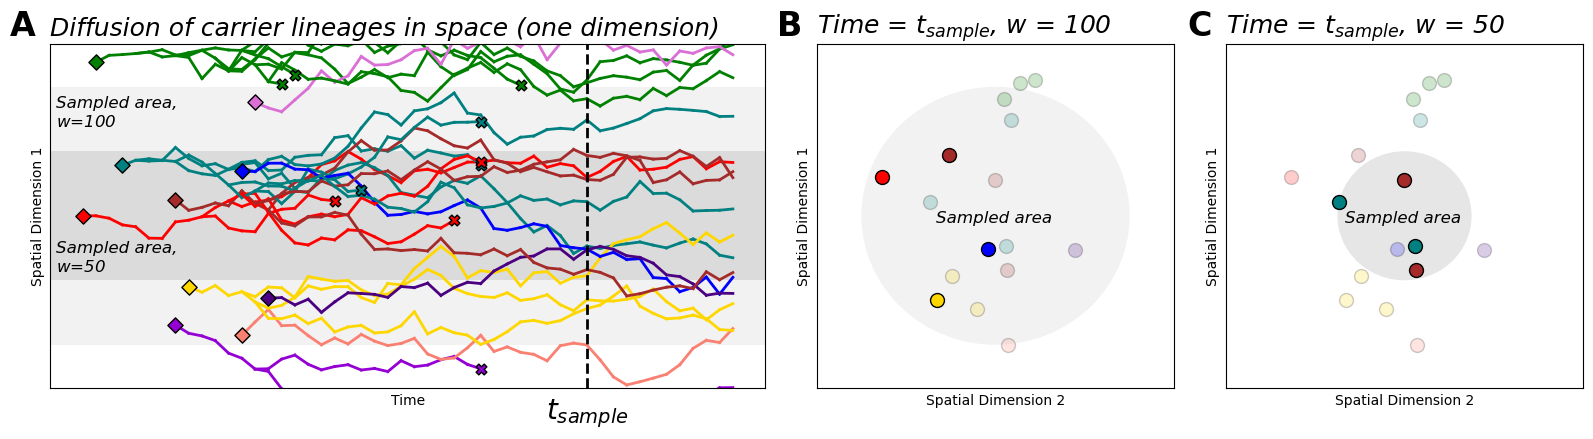

In [5]:
fig = plt.figure(figsize=(16,4.5)) 
gs = GridSpec(1, 3, width_ratios=[2, 1, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

time_slice = 38
lim=100
sample_lim = 75
num_particles = 1
steps = 50
branch_prob = 0.2
death_prob = 0.01
diff_std = 5.0
seed = 60627#np.random.randint(0,100000,1)
smin = -100
smax = 100
new_particle_prob = 0.03
np.random.seed(seed)
print(seed)

positions, alive, colors, births, deaths, live_counts, live_counts_sample, newparticles = branching_diffusion_with_death(num_particles, 
                                                                          steps, branch_prob, 
                                                                          death_prob, diff_std,
                                                                          max_particles=30, smin=smin,
                                                                          smax=smax, new_particle_prob=new_particle_prob)

for i in range(positions.shape[1]):
    alive_indices = np.where(alive[:, i])[0]
    if alive_indices.any():
        for j in range(len(alive_indices)-1):
            if alive_indices[j+1] - alive_indices[j] == 1:
                ax1.plot(range(alive_indices[j], alive_indices[j+1]+1), 
                         positions[alive_indices[j]:alive_indices[j+1]+1, i], 
                         color=colors[i], linewidth=2)

for death in deaths:
    ax1.scatter(death[0], death[1], c=death[2], marker='X', s=60, zorder=3, edgecolors='black')

ax1.scatter(0, 0, marker='D', color=colors[0], s=60, zorder=3, edgecolors='black')  
for part in newparticles:
    ax1.scatter(part[0], part[1], marker='D', color=part[2], s=60, zorder=3, edgecolors='black')    

ax1.set_xlabel("Time")
ax1.set_ylabel("Spatial Dimension 1") 

ax1.set_yticks([0])
ax1.axvline(x=time_slice,linestyle='dashed',linewidth=2,color='black')
ax1.annotate(r'$t_{sample}$',xy=(time_slice,0),xytext=(time_slice, -105),fontsize=20,fontweight='bold',
             ha='center', va='top')
ax1.set_ylim(-lim,lim)
ax1.axhspan(-sample_lim, sample_lim, facecolor='gray', alpha=0.1, edgecolor='none')
ax1.axhspan(-sample_lim/2, sample_lim/2, facecolor='gray', alpha=0.2, edgecolor='none')


alive_indices = np.where(alive[time_slice])[0]
y_positions = positions[time_slice, alive_indices]
np.random.seed(56891)#60605
unique_colors = np.unique(colors)
color_to_xpos = {color: np.random.normal(0,lim*0.3) for color in unique_colors}
x_positions = [color_to_xpos[colors[i]] + np.random.randn() * 20 for i in alive_indices]

np.random.seed(21097)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

circle = patches.Circle((0, 0), sample_lim, linewidth=1, edgecolor='none', facecolor='gray', alpha=0.1)
ax2.add_patch(circle)

within_circle_indices = [i for i, (x, y) in enumerate(zip(x_positions, y_positions)) if np.sqrt(x**2 + y**2) <= sample_lim]
selected_indices = np.random.choice(within_circle_indices, size=min(4, len(within_circle_indices)), replace=False)
for i, (x, y) in enumerate(zip(x_positions, y_positions)):
    distance = np.sqrt(x**2 + y**2)
    if i in selected_indices:
        alpha = 1.0
    else:
        alpha = 0.2
    ax2.scatter(x, y, color=colors[alive_indices[i]], marker='o', s=100, edgecolors='black', alpha=alpha)
    
ax2.set_xlabel("Spatial Dimension 2")
ax2.set_ylabel("Spatial Dimension 1")

np.random.seed(3228)

ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)

circle = patches.Circle((0, 0), sample_lim/2, linewidth=1, edgecolor='none', facecolor='gray', alpha=0.1)
ax3.add_patch(circle)
ax3.add_patch(circle)

within_circle_indices = [i for i, (x, y) in enumerate(zip(x_positions, y_positions)) if np.sqrt(x**2 + y**2) <= sample_lim/2]
selected_indices = np.random.choice(within_circle_indices, size=min(4, len(within_circle_indices)), replace=False)
for i, (x, y) in enumerate(zip(x_positions, y_positions)):
    distance = np.sqrt(x**2 + y**2)
    if i in selected_indices:
        alpha = 1.0
    else:
        alpha = 0.2
    ax3.scatter(x, y, color=colors[alive_indices[i]], marker='o', s=100, edgecolors='black', alpha=alpha)

ax3.set_xlabel("Spatial Dimension 2")
ax3.set_ylabel("Spatial Dimension 1")


for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])

matplotlib.rcParams['axes.labelsize'] = 18

# ax1.set_title('Weaker selection', loc='left', fontstyle='italic',fontsize=20)
# ax2.set_title('Stronger selection', loc='left', fontstyle='italic',fontsize=20)

ax1.set_title(r'Diffusion of carrier lineages in space (one dimension)', loc='left', fontstyle='italic',fontsize=18)
ax2.set_title(r'Time = $t_{sample}$, $w$ = 100', loc='left', fontstyle='italic',fontsize=18)
ax3.set_title(r'Time = $t_{sample}$, $w$ = 50', loc='left', fontstyle='italic',fontsize=18)


ax1.text(-2,52,'Sampled area,\n$w$=100',fontsize=12,fontstyle='italic')
ax1.text(-2,-32,'Sampled area,\n$w$=50',fontsize=12,fontstyle='italic')

ax2.text(-33.5,-3.6,'Sampled area',fontsize=12,fontstyle='italic')
ax3.text(-33.5,-3.6,'Sampled area',fontsize=12,fontstyle='italic')

ax1.text(-0.02, 1.1, 'A', transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
ax2.text(-0.04, 1.1, 'B', transform=ax2.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
ax3.text(-0.04, 1.1, 'C', transform=ax3.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')
plt.tight_layout()
plt.savefig("schematic_v9.pdf")
plt.show()        